In [ ]:
# step 1: feature selection, target will be A (predict whether the user will see the ad or not) using V1-V200
# step 2: segment the users based on selected features
# step 3: In the same user cluster, compare Y between users with A=1 and users with A=0, 
#         to see A (whether see the ad or not) will affect Y

In [2]:
import pandas as pd #pip install pandas
import numpy as np #pip install numpy
from sklearn.feature_selection import SelectKBest, chi2, RFE, SelectFromModel #pip install -U scikit-learn
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LogisticRegression 
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from lightgbm import LGBMClassifier #pip install lightgbm
from matplotlib import pyplot as plt #pip install matplotlib
import seaborn as sns #pip install seaborn
from cycler import cycler

In [3]:
df=pd.read_csv("Data Science data.csv") #data file and ipynb file in the same folder
df.isnull().sum().sum() #return 0, no missing data
df.shape[0] == df['user_id'].nunique() #all users are unique

True

In [4]:
#1 use users' individual characteristics(V1-V200) to predict whether user will see the ads(A), and select important features
y = df['A']
X = df.iloc[:,3:]
feature_name = list(X.columns)

# try to select 100 features
num_feats=100

In [5]:
#1.1 feature selection using Pearson correlation. 
# We check the absolute value of the Pearson's correlation between the target and numerical features in our dataset. 
# We keep the top 100 features based on this criterion.
def cor_selector(X, y,num_feats):
    cor_list = []
    feature_name = X.columns.tolist()
    
    # calculate the correlation with y for each feature
    for i in X.columns.tolist():
        cor = np.corrcoef(X[i], y)[0, 1]
        cor_list.append(cor)
        
    # replace NaN with 0
    cor_list = [0 if np.isnan(i) else i for i in cor_list]
    
    # feature name, argsort return index of values from samll to large
    cor_feature = X.iloc[:,np.argsort(np.abs(cor_list))[-num_feats:]].columns.tolist()
    
    # feature selection based on Pearson correlation 
    cor_support = [True if i in cor_feature else False for i in feature_name]
    
    return cor_support, cor_feature

cor_support, cor_feature = cor_selector(X, y,num_feats)

In [6]:
#1.2 feature selection using Chi-Square values.
# we calculate the chi-square metric between the target and the numerical variable and 
# only select the variable with the maximum chi-squared values.
X_norm = MinMaxScaler().fit_transform(X)
chi_selector = SelectKBest(chi2, k=num_feats)
chi_selector.fit(X_norm, y)
chi_support = chi_selector.get_support()
chi_feature = X.loc[:,chi_support].columns.tolist()

In [7]:
#1.3 feature selection using recursive feature elimination (RFE)
# The goal of RFE is to select features by recursively considering smaller and smaller sets of features.
rfe_selector = RFE(estimator=LogisticRegression(solver='liblinear'), n_features_to_select=num_feats, step=10, verbose=5)
rfe_selector.fit(X_norm, y)
rfe_support = rfe_selector.get_support()
rfe_feature = X.loc[:,rfe_support].columns.tolist()

Fitting estimator with 200 features.
Fitting estimator with 190 features.
Fitting estimator with 180 features.
Fitting estimator with 170 features.
Fitting estimator with 160 features.
Fitting estimator with 150 features.
Fitting estimator with 140 features.
Fitting estimator with 130 features.
Fitting estimator with 120 features.
Fitting estimator with 110 features.


In [8]:
#1.4 feature selection using Lasso, Lasso Regularizer forces a lot of feature weights to be zero
embeded_lr_selector = SelectFromModel(LogisticRegression(penalty="l1",solver="liblinear"), max_features=num_feats)
embeded_lr_selector.fit(X_norm, y)
embeded_lr_support = embeded_lr_selector.get_support()
embeded_lr_feature = X.loc[:,embeded_lr_support].columns.tolist()

In [9]:
#1.5 feature selection using LightGBM which is to select features based on feature importance
lgbc=LGBMClassifier(n_estimators=500, learning_rate=0.05, num_leaves=32, colsample_bytree=0.2,
            reg_alpha=3, reg_lambda=1, min_split_gain=0.01, min_child_weight=40)
embeded_lgb_selector = SelectFromModel(lgbc, max_features=num_feats)
embeded_lgb_selector.fit(X, y)
embeded_lgb_support = embeded_lgb_selector.get_support()
embeded_lgb_feature = X.loc[:,embeded_lgb_support].columns.tolist()

In [10]:
pd.set_option('display.max_rows', None)
# put all selection together
feature_selection_df = pd.DataFrame({'Feature':feature_name, 'Pearson':cor_support, 'Chi-2':chi_support, 'RFE':rfe_support, 
                                     'Logistics':embeded_lr_support,'LightGBM':embeded_lgb_support})

# count the selected times for each feature
feature_selection_df['Total'] = np.sum(feature_selection_df, axis=1)

# display the result
feature_selection_df = feature_selection_df.sort_values(['Total','Feature'] , ascending=False)
feature_selection_df.index = range(1, len(feature_selection_df)+1)
feature_selection_df.head(num_feats)

,Feature,Pearson,Chi-2,RFE,Logistics,LightGBM,Total
1,V99,True,True,True,True,True,5
2,V88,True,True,True,True,True,5
3,V78,True,True,True,True,True,5
4,V70,True,True,True,True,True,5
5,V25,True,True,True,True,True,5
6,V163,True,True,True,True,True,5
7,V148,True,True,True,True,True,5
8,V125,True,True,True,True,True,5
9,V118,True,True,True,True,True,5
10,V96,True,True,True,False,True,4


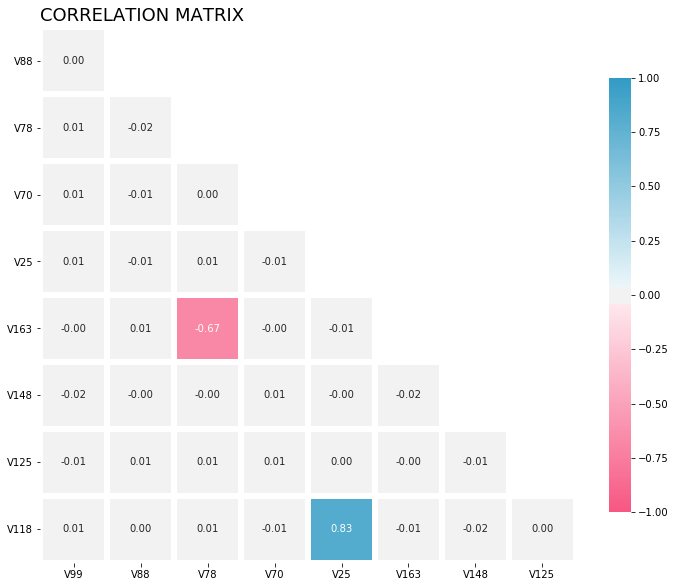

In [11]:
#2 customer segmentation based on selected features
#choose features selected by all the methods
selected_cols = feature_selection_df[feature_selection_df['Total']==5]['Feature']
data=df[selected_cols]

# get correlations
data_corr = data.corr()

#plot the correlations
fig, ax = plt.subplots(figsize=(12, 10))

# mask
mask = np.triu(np.ones_like(data_corr, dtype=bool)) 
# adjust mask and df
mask = mask[1:, :-1]
corr = data_corr.iloc[1:,:-1].copy()
# color map
cmap = sns.diverging_palette(0, 230, 90, 60, as_cmap=True)
# plot heatmap
sns.heatmap(corr, mask=mask, annot=True, fmt=".2f", 
           linewidths=5, cmap=cmap, vmin=-1, vmax=1, 
           cbar_kws={"shrink": .8}, square=True)
# ticks
yticks = [i.upper() for i in corr.index]
xticks = [i.upper() for i in corr.columns]
plt.yticks(plt.yticks()[0], labels=yticks, rotation=0)
plt.xticks(plt.xticks()[0], labels=xticks)
# title
title = 'CORRELATION MATRIX'
plt.title(title, loc='left', fontsize=18)
plt.show()

#Two pairs of features are highly correlated, with limited information about the features, 
#removing the features are not considered now

In [12]:
# Scale and center the data, hence variables have similar average values 
# and similar standard deviation values
scaler = StandardScaler()
scaler.fit(data)
data_normalized = scaler.transform(data)
data_norm = pd.DataFrame(data=data_normalized, index=data.index, columns=data.columns)

In [13]:
# Fit KMeans and calculate  sum of squared error (SSE) for each k
sse = {}

for k in range(1, 21):
  
    # Initialize KMeans with k clusters
    kmeans = KMeans(n_clusters=k, random_state=1)
    
    # Fit KMeans on the normalized dataset
    kmeans.fit(data_norm)
    
    # Assign sum of squared distances to k element of dictionary
    sse[k] = kmeans.inertia_

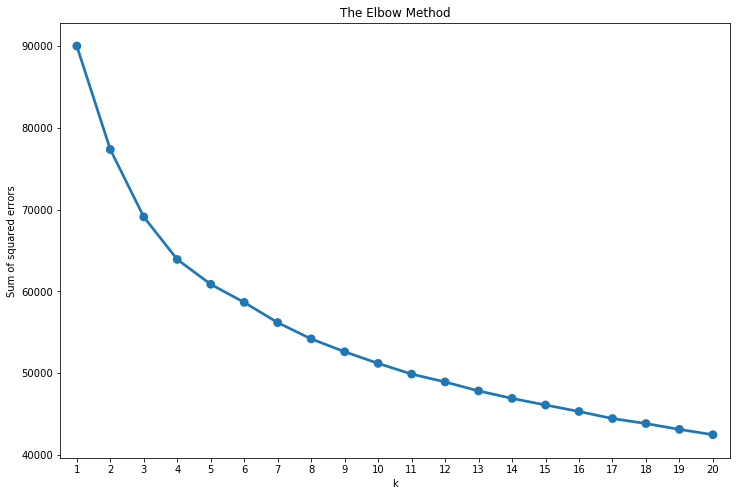

In [14]:
plt.figure(figsize=(12,8))

plt.title('The Elbow Method')
plt.xlabel('k'); 
plt.ylabel('Sum of squared errors')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

In [15]:
#try k=7
kmeans = KMeans(n_clusters=7, random_state=1)

# Compute k-means clustering on pre-processed data
kmeans.fit(data_norm)

# Extract cluster labels from labels_ attribute
cluster_labels = kmeans.labels_

# Create a cluster label column in the clustering data
data_k7 = data.assign(Cluster = cluster_labels)

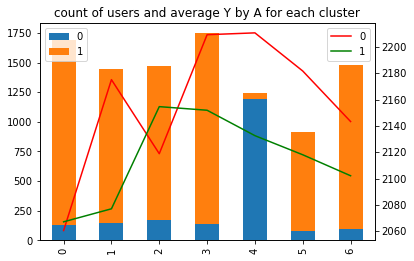

In [16]:
#3 compare the average Y values between users who see ads and users who do not see ads for each cluster
# Create a cluster label column in the original data
df = df.assign(Cluster = cluster_labels)

#plot the result 
ax1=df.groupby(['Cluster','A'])['user_id'].count().unstack().plot(
    stacked=True,kind='bar',title='count of users and average Y by A for each cluster',xlabel='')
ax1.legend(loc='upper left')

plt.rc('axes', prop_cycle=(cycler('color', ['r', 'g'])))
df.groupby(['Cluster','A'])['Y'].mean().unstack().plot(ax=ax1.twinx()).legend(loc='upper right') 
plt.show()

Since the detailed description of users' features are not provided, limited feature engineering can be done.

Tried to use clustering method to group users by their selected individual characteristics, users in each cluster are considered to be quite similar.

Users' clustering still have much room to improve, can try different combinations of features, different numbers of clusters or other models. Evaluation of clustering is difficult due to limited information.

In each cluster, we can treat users who do not see ads as control and users who see the ads as experiment, study their differences and explain the Y outcome, similar to A/B test.

From the result, we can see the cluster 4 has a lot of people who do not see the ads, indicating the clustering model has caught some characteristics shared by this group of users who are not attracted by the ads.

Impact of ads is different for different clusters, it is expected that cluster 4 should behave quite differently compared to other clusters but the plot does not show this.